# Malaria cell detection using VGG 16 pretrained model weights
<b>Abstract</b>:&nbsp;Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected mosquitoes. Automation of the diagnosis process will enable accurate diagnosis of the disease and hence holds the promise of delivering reliable healthcare to resource-scarce areas. Machine learning technologies have been used for automated diagnosis of malaria. We present some of our recent progresses on highly accurate classification of malaria-infected cells using deep convolutional neural networks. First, we describe image processing methods used for segmentation of red blood cells from wholeslide images. We then discuss the procedures of compiling a pathologists-curated image dataset for training deep neural network, as well as data augmentation methods used to significantly increase the size of the dataset, in light of the overfitting problem associated with training deep convolutional neural networks. We will then compare the classification accuracies obtained by deep convolutional neural networks through training, validating, and testing with various combinations of the datasets. These datasets include the original dataset and the significantly augmented datasets, which are obtained using direct interpolation, as well as indirect interpolation using automatically extracted features provided by stacked autoencoders. This chapter ends with a discussion of further research.

<b>Cell image pre-processing and compilation of dataset for deep learning</b>:&nbsp;
The images used in this work were whole slide images provided in the PEIR-VM repository built by the University of Alabama in Birmingham. The original whole slide image data contain significant amount of redundant information. In order to achieve good classification accuracy, image segmentation and de-noising are needed to extract only blood cells and remove those redundant image pixels simultaneously. Several effective image processing techniques were used to accurately segment tiles into individual cells.

<b>Task</b>:&nbsp;Now we have to Regcognise the future images and give the prediction result

<b>Importing the library</b>

In [1]:
#importing the library
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras import applications
from datetime import datetime as dt
from keras import regularizers as reg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")
from keras.callbacks import ModelCheckpoint

/home/suvhradip/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Get bottleneck Features

In [ ]:
global_start=dt.now()

#Dimensions of our flicker images is 256 X 256
img_width, img_height = 256, 256

#Declaration of parameters needed for training and validation
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
epochs = 40
batch_size = 16

#Get the bottleneck features by  Weights.T * Xi
def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1./255)

    #Load the pre trained VGG16 model from Keras, we will initialize only the convolution layers and ignore the top layers.
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator_tr = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode=None, #class_mode=None means the generator won't load the class labels.
                                            shuffle=False) #We won't shuffle the data, because we want the class labels to stay in order.
    nb_train_samples = len(generator_tr.filenames) #3600. 1200 training samples for each class
    bottleneck_features_train = model.predict_generator(generator_tr, nb_train_samples // batch_size)
    np.save('weights/bottleneck_features_train_14.npy',bottleneck_features_train) #bottleneck_features_train is a numpy array

    generator_ts = datagen.flow_from_directory(validation_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    nb_validation_samples = len(generator_ts.filenames) #1200. 400 training samples for each class
    bottleneck_features_validation = model.predict_generator(generator_ts, nb_validation_samples // batch_size)
    np.save('weights/bottleneck_features_validation_14.npy',bottleneck_features_validation)
    print("Got the bottleneck features in time: ",dt.now()-global_start)
    
    num_classes = len(generator_tr.class_indices)
    
    return nb_train_samples,nb_validation_samples,num_classes,generator_tr,generator_ts
    
nb_train_samples,nb_validation_samples,num_classes,generator_tr,generator_ts=save_bottlebeck_features()

Found 1950 images belonging to 14 classes.


<b>VGG 16 Pretrained Weights&nbsp;:</b><br>

In [13]:
num_classes=14
#After we get the bottleneck features, we will build the top fully connected layers on top of the bottlneck features. Let's build the top layers.
def train_top_model():
    global_start=dt.now()

    train_data = np.load('weights/bottleneck_features_train_14.npy')
    validation_data = np.load('weights/bottleneck_features_validation_14.npy')
    
    #train_labels = np.array([0] * (nb_train_samples // 3) + [1] * (nb_train_samples // 3) + [2] * (nb_train_samples // 3)) #Equivalent to: np.array([0]*1200 + [1]*1200 + [2]*1200)
    #validation_labels = np.array([0] * (nb_validation_samples // 3) + [1] * (nb_validation_samples // 3) + [2] * (nb_validation_samples // 3))
    train_labels=generator_tr.classes  
    validation_labels=generator_ts.classes
    
    train_labels = to_categorical(train_labels, num_classes=num_classes)  
    validation_labels = to_categorical(validation_labels, num_classes=num_classes)  

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) #Ignore the first index. It contains ID

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001))) #Best weight initializer for relu is he_normal
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5)) #Using droput for regularization

    model.add(Dense(256, activation='relu',kernel_initializer='he_normal',kernel_regularizer=reg.l1_l2(l1=0.001, l2=0.001)))
    model.add(BatchNormalization()) #Add a BatchNormalization layer to control internel covariance shift
    model.add(Dropout(rate=0.5))

    model.add(Dense(num_classes, activation='softmax',kernel_initializer='glorot_uniform')) #Because we have 3 classes. Remember, softmax is to multi-class, what sigmoid (log reg) is to binary

    optim=RMSprop(lr=0.0001, epsilon=1e-8, decay=1e-6)
    model.compile(loss='categorical_crossentropy',optimizer=optim,metrics=['accuracy'])
    model.summary()
    
    #Save the weights for the best epoch accuracy
    checkpointer = ModelCheckpoint(filepath="weights/bottleneck_feats_multi_weights_14_checkpoint.hdf5", monitor = 'val_acc',verbose=1, save_best_only=True)
                                   
    model.fit(x=train_data,
              y=train_labels,
              epochs=epochs,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpointer])    
    
    #Refit our model with the best weights saved before
    model.load_weights('weights/bottleneck_feats_multi_weights_14.hdf5')
    model.save('weights/bottleneck_feats_multi_model_14.h5')
    print("The top layer trained in time: ",dt.now()-global_start)
    
    return model

model=train_top_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               8388864   
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
__________

ValueError: Input arrays should have the same number of samples as target arrays. Found 1936 input samples and 1950 target samples.

In [7]:
train_data = np.load('weights/bottleneck_features_train.npy')
validation_data = np.load('weights/bottleneck_features_validation.npy')

train_labels = to_categorical(generator_tr.classes, num_classes=num_classes)  
validation_labels = to_categorical(generator_ts.classes, num_classes=num_classes)

#Plot the train and test loss vs number of epochs
score = model.evaluate(validation_data, validation_labels, verbose=0) 
print('Test score (Validation Loss):', score[0]) 
print('Test accuracy (Accuracy on Unseen Data):', score[1])


Test score (Validation Loss): 1.7766318798065186
Test accuracy (Accuracy on Unseen Data): 0.8325


<h1>Visualization of Training Loss and test loss</h1>

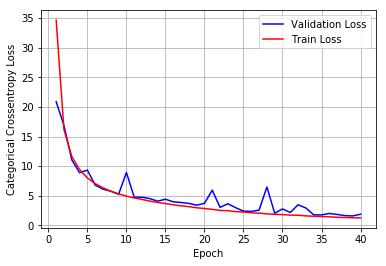

In [9]:
#This function is used to plot/update the train and test loss after each epoch.
import matplotlib.pyplot as plt
def plt_dynamic_loss(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

#Get model history
history=model.history

#Plot train vs test loss
fig,ax = plt.subplots(1,1)
ax.set_xlabel('Epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

#List of epoch numbers
x = list(range(1,epochs+1))

#Display the loss
val_loss = history.history['val_loss'] #Validation Loss
loss = history.history['loss'] #Training Loss
plt_dynamic_loss(x, val_loss, loss, ax)

In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('cell_images/test.png', target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = classifier.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
    prediction = 'Parasitized'
else:
    prediction = 'Uninfected'